In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tushare as ts
import matplotlib.pyplot as plt
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
stock_info_df = pd.read_csv("list.csv")

In [3]:
stock_info_df[:5]

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,1,平安银行,深圳,银行,19910403
1,000002.SZ,2,万科A,深圳,全国地产,19910129
2,000004.SZ,4,国农科技,深圳,生物制药,19910114
3,000005.SZ,5,世纪星源,深圳,房产服务,19901210
4,000006.SZ,6,深振业A,深圳,区域地产,19920427


In [4]:
info = stock_info_df[stock_info_df['name']=='长城动漫']
print(info)

       ts_code  symbol  name area industry  list_date
344  000835.SZ     835  长城动漫   四川     影视音像   19990625


In [5]:
stock_data_df = ts.get_hist_data('000835')

In [25]:
today = time.strftime('%Y-%m-%d',time.localtime(time.time()))
stock_data_df.loc[today:"2019-03-01"]

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2019-03-08,5.25,5.36,4.93,4.93,206333.14,-0.55,-10.04,5.164,4.872,4.515,220592.71,160074.10,107258.28
2019-03-07,5.37,5.54,5.48,5.33,287239.44,-0.12,-2.14,5.104,4.812,4.459,194094.45,145954.17,99264.57
2019-03-06,5.50,5.65,5.60,5.31,422478.47,0.46,8.95,4.924,4.688,4.364,151391.15,125230.87,88543.00
2019-03-05,4.61,5.14,5.14,4.60,66883.12,0.47,10.06,4.734,4.555,4.272,92494.63,88428.00,69808.74
2019-03-04,4.80,4.87,4.67,4.63,120029.37,0.04,0.86,4.610,4.466,4.211,101434.52,89337.67,70424.93
2019-03-01,4.61,4.67,4.63,4.50,73841.85,0.05,1.09,4.580,4.420,4.186,99555.49,83327.03,71598.22


In [7]:
## 保持x、y对齐。target去掉最后一列，df去掉第一列。
target = stock_data_df.iloc[:-1,2].as_matrix().astype(np.float32)
data  = stock_data_df.iloc[1:].as_matrix().astype(np.float32)

In [8]:
target_train,target_test,data_train,data_test = target[50:].reshape(-1,1),target[:50].reshape(-1,1),data[50:],data[:50]

In [9]:
target_train.shape,target_test.shape,data_train.shape,data_test.shape,type(data_train[0][0])

((539, 1), (50, 1), (539, 13), (50, 13), numpy.float32)

In [80]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32,shape=[None,13],name="input_X")
y = tf.placeholder(dtype=tf.float32,shape=[None,1],name="input_Y")
# 定义网络
net = tf.contrib.layers.batch_norm(x)
net = slim.fully_connected(net,8,activation_fn=tf.nn.relu)
net = tf.contrib.layers.batch_norm(net)
net = slim.fully_connected(net,8,activation_fn=tf.nn.relu)
net = tf.contrib.layers.batch_norm(net)
net = slim.fully_connected(net,1,activation_fn=None)
loss = tf.reduce_mean(tf.square(net-y))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for itr in range(50000):
    loss_var,_ = sess.run([loss,train_step],feed_dict={x:data_train,y:target_train})
    if itr%2000==0:
        print(itr,loss_var)
y_predict = sess.run(net,feed_dict={x:data})
today = stock_data_df.iloc[:1].as_matrix().astype(np.float32)
today = today.reshape(1,13)
next_day = sess.run(net,feed_dict={x:today}) 

0 85.90506
2000 0.042203255
4000 0.034057677
6000 0.02993688
8000 0.02710875
10000 0.024381623
12000 0.022637345
14000 0.02196386
16000 0.021492451
18000 0.02117493
20000 0.020755444
22000 0.019941635
24000 0.019770475
26000 0.019616866
28000 0.019507932
30000 0.019204222
32000 0.019060448
34000 0.018902497
36000 0.018825546
38000 0.018697847
40000 0.018520836
42000 0.018435614
44000 0.018386364
46000 0.018273175
48000 0.018163621


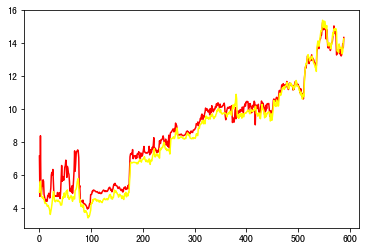

In [81]:
plt.plot(y_predict,color="red",label="预测")
plt.plot(target,color="yellow",label="真实")
plt.show()

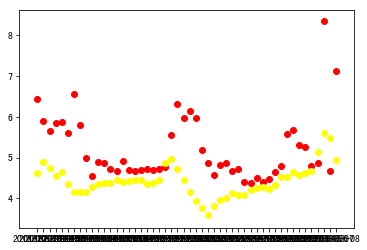

In [82]:
index_label = stock_data_df.index
plt.scatter(index_label[:50],y_predict[:50],color="red",label="预测")
plt.scatter(index_label[:50],target[:50],color="yellow",label="真实")
plt.show()

In [83]:
next_day

array([[8.710858]], dtype=float32)

## <font color="red">随机森林，多选几只股票。</font>
## <font color="red">无监督学习，识别庄家。</font>
## 图像识别K线图、自然语言处理，情分分析，subject 发现、文章分类。

浅谈量化
最近在一篇论文的研究中看到，如今的证券市场，60%的指令是由程序发出的，80%以上的美国大型基金以及三分之一的亚洲大型基金，均已使用量化投资策略。

# 涨停价位的计算是:前一日收盘价+(前一日收盘价×10%)